# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import itertools
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM 

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.utils.data import evaluate_print


### Load the Data

In [149]:
def load_data(filename):

    df = pd.read_csv(filename)
    return df

df = load_data("data_mamography.csv")

### Describe and Basic Visaulization

---
Data Shape:
Total Records 4032
Total Columns 2
Column Names ['timestamp', 'value']
---
Descriptive Stats:
             value
count  4032.000000
mean     43.110372
std       4.303565
min      34.766000
25%      39.296000
50%      42.918000
75%      46.006000
max      68.092000
Column: timestamp
Column is non-integer
Column: value
Skew: 0.5198726143729384
Kurtosis: -0.25370876372365103


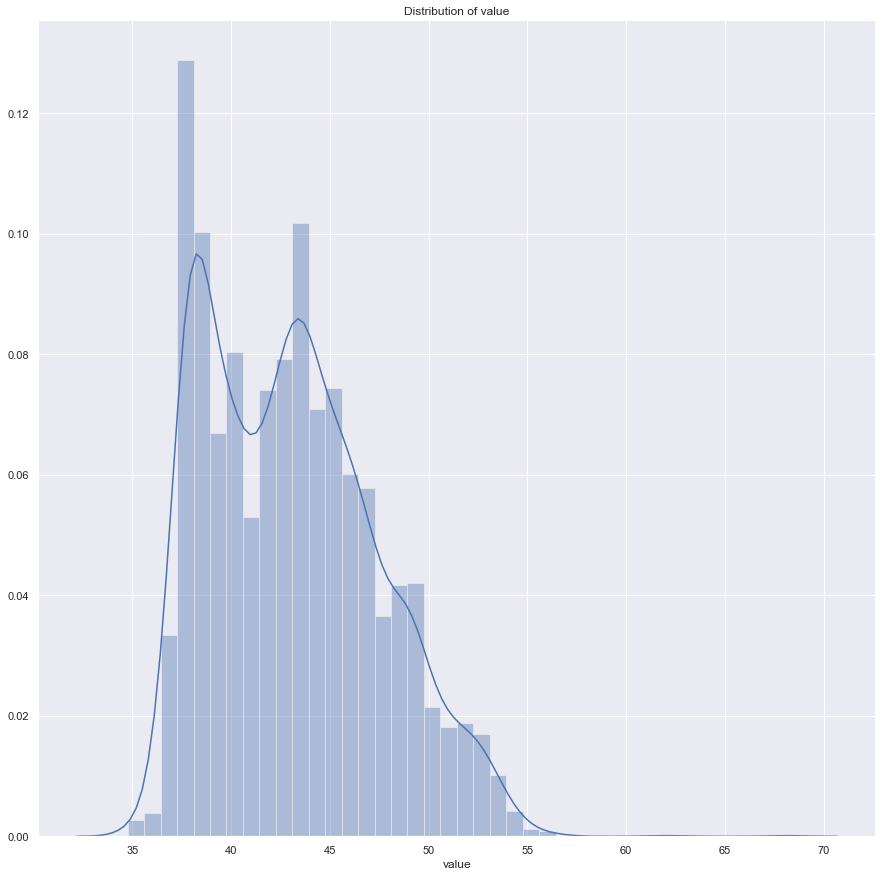

Cross Attribute Plot:


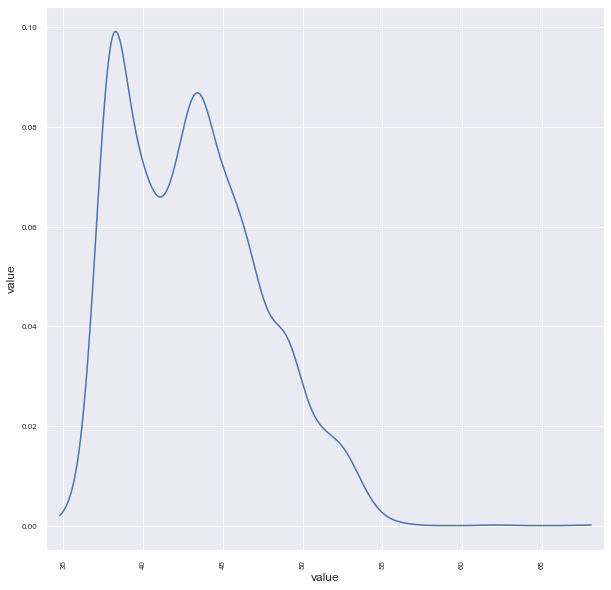

In [148]:
def describe_data(df):
    print('---')
    print('Data Shape:')
    print('Total Records {}'.format(df.shape[0]))
    print('Total Columns {}'.format(df.shape[1]))
    print('Column Names {}'.format(list(df.columns)))
    print('---')
    print('Descriptive Stats:')
    print(df.describe())
    
    for col in df.columns:
        print('Column: {}'.format(col))
        try:
            print('Skew: {}'.format(df[col].skew()))
            print('Kurtosis: {}'.format(df[col].kurt()))
#             df[col].hist()
#             plt.show()
            sns.distplot(df[col])
            plt.title("Distribution of {}".format(col))
            sns.despine()
            plt.show()

        except:
            print('Column is non-integer')
            
    print('Cross Attribute Plot:')
    scatter_matrix(df, alpha=0.2, figsize=(10, 10), diagonal='kde')    
    plt.show()
        
describe_data(df)

### Prepare Data

In order to use the dataset for modelling purposes, we're first going to do some transformation on the data to make it easier to apply certain methods to.

In [69]:
def prep_data(df, to_shuffle = True, standardize_target = True):
    
    if to_shuffle:
        df = df.sample(frac=1)
        
    if standardize_target: 
        df['class'] = df['class'].replace({"'-1'": -1, "'1'": 1})

    return df


df = prep_data(df)
    

## Modelling for Anomaly Detection

For the detection of outliers or 'Anomalies', we will attemp to examine different algorithms suitable for performing uni- and multi-varient modelling.

**Note on Feature Engineering / Feature Selection**

However, as we're going to be working with multiple features, we typically need to work out which features are going to be affecting the models performance.

This can be a very complex exercise, typically before we start to work with data, we need to determine codependencies, and if we can construct new features which represent a higher order polynomial to draw out linear features).

For this example. We're going to develop a grid search mechanism, to determine the best combination of features to use.

### Parameter Grid Search

In [79]:
def generate_parameter_grid_combinations(df, target_col_name):
    
    
    #first, select the features from the columns
    features = []
    for col in df.columns:
        if (col != target_col_name) and (col != 'preds'):
            features.append(col)
            
#     print(features)
    #now these are the features we need to create all permutations.
    combinations = []
    for feat_nums in range(1, len(features)+1):
        feat_comb = itertools.combinations(features,feat_nums)
        for x in feat_comb:
            combinations.append(list(x))
            
    print('Total {} Combinations Generated'.format(len(combinations)))
    return combinations

feature_combinations = generate_parameter_grid_combinations(df, 'class')    

Total 63 Combinations Generated


### Modelling - Unsupervised

In this first attempt, we're going to use a unsupervised approach. 

For this, we're going to start with isolation forests, a tree based model which using sampling techniques and anomaly scores, determines whether a data point represents an outlier (based on score).

**Isolation Forest: Anomaly Score**
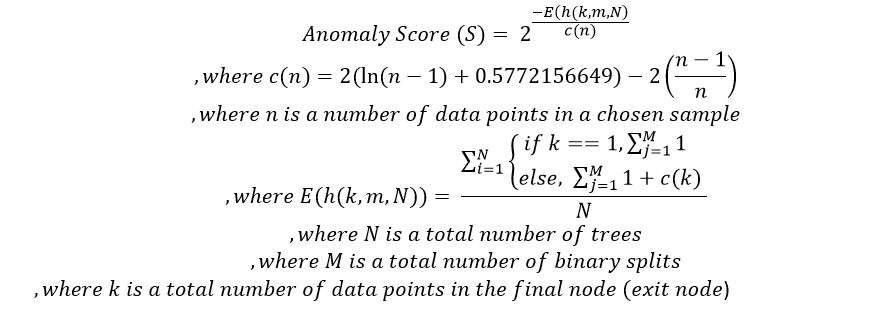

In [139]:
def isolation_forest(df, features = None, target_col_name='class'):
    
    #first, select the features from the columns
    if features == None:
        features = []
        for col in df.columns:
            if (col != target_col_name) and (col != 'preds'):
                features.append(col)
    
    print(features)
    
    clf=IsolationForest(n_estimators=1000, max_samples='auto', contamination=float(.05), 
                        bootstrap=False, n_jobs=-1, 
                        random_state=42, verbose=0)
    
    clf.fit(df[features])
    preds = clf.predict(df[features])
#     print(preds)
    return clf, preds
iso_forest_model, preds = isolation_forest(df, target_col_name='class')

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']


In [140]:
def calculate_model_performance(df, target_col_name, target_class_label, preds, printoutput = False):

    df['preds'] = preds
    outliers=df.loc[df['preds']==-1]
    outlier_index=list(outliers.index)
    #print(df['preds'].value_counts())        
#     print(df['class'])
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for idx,row in df.iterrows():
        if row[target_col_name] == target_class_label: #assumes 1 is 
            if row['preds'] == target_class_label:
    #             print('True Positive')
                tp += 1
            else:
                fn += 1
        else:
            if row['preds'] == target_class_label:
    #             print('False Positive')
                fp += 1
            else:
                tn += 1
            
    positive_classes = df[target_col_name][df[target_col_name] == target_class_label].count()
    negative_classes = df[target_col_name][df[target_col_name] == -target_class_label].count()
    class_report = classification_report(df[target_col_name], df['preds'])
    
    if printoutput:
        print('Positive Records {}, Negative Records {}'.format(positive_classes, negative_classes))
        print('Detection Results (Absolute):')
        print('True Positive {}'.format(tp))
        print('True Negative {}'.format(tn))
        print('False Positive {}'.format(fp))
        print('False Negative {}'.format(fn))

        #And use Classification Report from Skit-Learn
        target_names = ['Positive', 'Negative']
        print(class_report)#, target_names=target_names))
        
    return class_report, tp, tn, fp, fn

              
    
# class_report = calculate_model_performance(df, target_col_name='class', target_class_label=1,
#                                            preds=preds, printoutput=True)

#### Interpretation of Model Results

If we take a look a the results, we can see that the model has a tendency to provide a high number of false positives. In respect to the context of the dataset, isn't necessarily a bad thing. We would rather perform further diagnostics for a given patient, rather than missdiagnose a True Positive as False Negative. Furthermore, the rate at which it is detecting True Positives is high, which we can view via the confusion matrix; Recall of the Positive Matches is 67% - Recall is TP / (TP + FP)). Recall in this example is an important metric we need to focus on; it's the ability of a model to find all the relevant cases within a dataset.

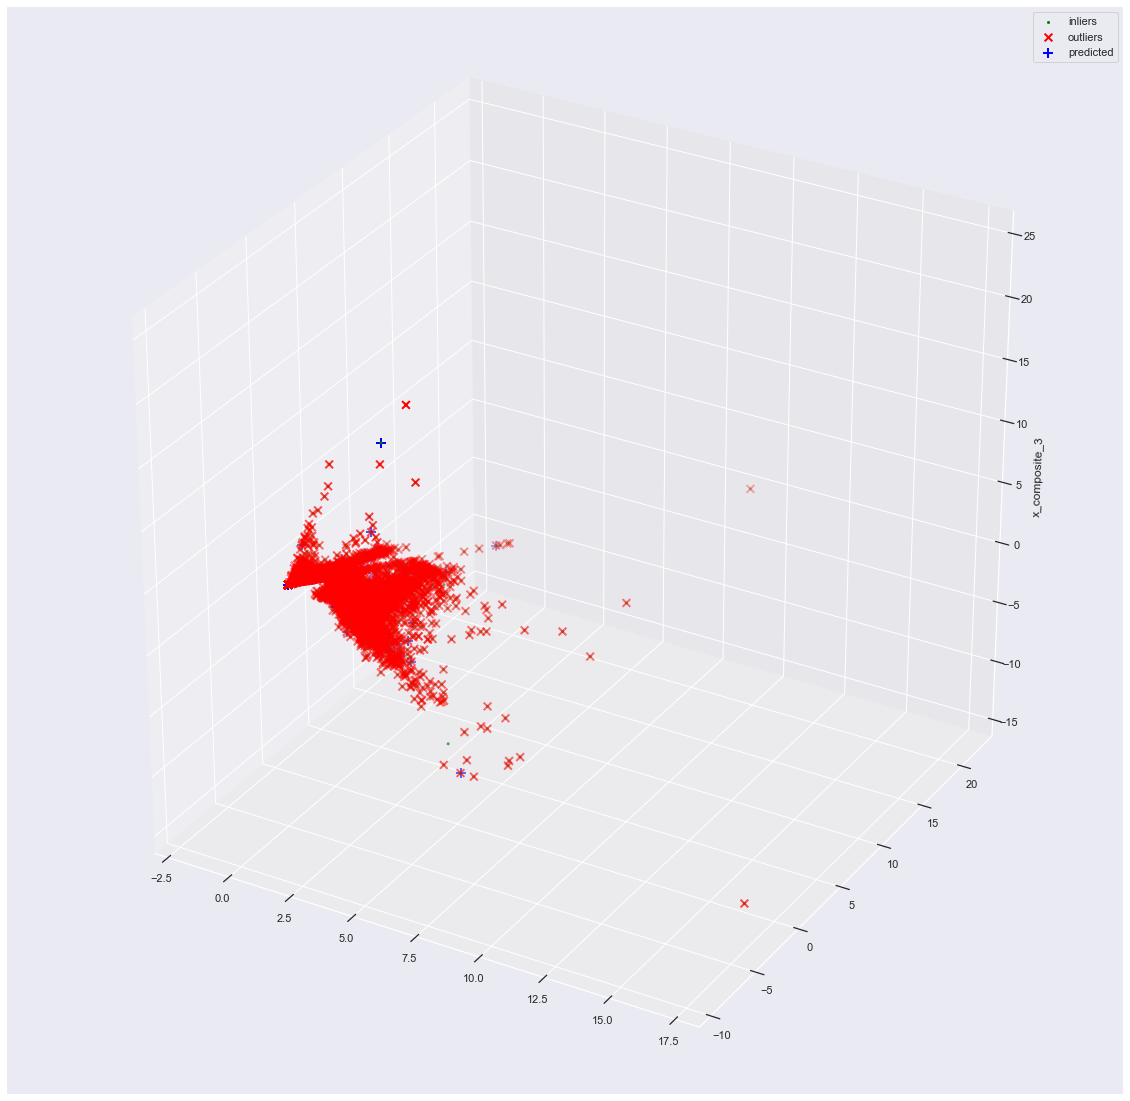

In [141]:
def plot_outliers_dimensions(df, preds, target_col_name = 'class', features = None):
    
    #first, select the features from the columns
    if features == None:
        features = []
        for col in df.columns:
            if (col != target_col_name) and (col != 'preds'):
                features.append(col)
                
    outliers=df.loc[df['class']==-1]
    outlier_index=list(outliers.index)

    df['preds'] = preds 
    pred_outliers=df.loc[df['preds']==-1]
    pred_outliers_index=list(pred_outliers.index)


    pca = PCA(n_components=3)  # Reduce to k=3 dimensions
    scaler = StandardScaler()
    #normalize the metrics
    X = scaler.fit_transform(df[features])
    X_reduce = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_zlabel("x_composite_3")
    # Plot the compressed data points
    ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
    # Plot x's for the ground truth outliers
    ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
               lw=2, s=60, marker="x", c="red", label="outliers")
    #plot x's for the 
    ax.scatter(X_reduce[pred_outliers_index,0],X_reduce[pred_outliers_index,1], X_reduce[pred_outliers_index,2],
               lw=2, s=100, marker="+", c="blue", label="predicted")
    ax.legend()
    plt.show()
    
plot_outliers_dimensions(df, preds, features = None)

### Improving our Model's Use of Data

Once we've run a first pass over the data, it's now time to see if we can improve the performance of the model. Given that we are limited with the data we are using, and the aim here is not to build a supervised training model, but an unsupervised model, we will then explore the use of feature selection and engineering to determine whether the feature's we're using are a good datapoint for the model.

### Feature Grid Search

One approach for selecting the most appropriate featre is the use of a grid search. Whilst it is a brute force method, e.g. it does not work in a sophistocated approach to prune the search space, it provides a simple, yet affective way to examine how the combination of parameters affect the performance of the model.

In short the following steps will be performned:
 - Compute all combinations of the feature space (e.g. if three features X1, X2, X3, we generate the non-unique combinations (X1), (X2), (X3), (X1,X2), (X1,X3), (X2,X3), (X1,X2,X3)
 - Iterate through all combinations and fit a model. and compute the predictions for the dataset
 - Iterate through all combinations and their predicted score and select the top n combinations which yield the most suitable result based on a defined metric of goodness (e.g. f1, accuracy, false positive rate, recall, etc)

In [266]:
def find_best_feature_combination(df, feature_combinations, model_type = 'isolation_forest'):
    
    feature_preds = {}
    for feature_comb in feature_combinations:
        if model_type == 'isolation_forest':
            preds = isolation_forest(df, features = feature_comb, target_col_name='class')
        elif model_type == 'oneclass_svm':
            preds = oneclass_svm(df, features = feature_comb, target_col_name='class')
        feature_preds[str(feature_comb)] = preds
    return feature_preds

feature_preds = find_best_feature_combination(df, feature_combinations, model_type = 'isolation_forest')

In [275]:
#the following method is used to identify which attribute combination yields the highest detection of outliers
def find_best_feature_combination(feature_preds, df, target_col, target_class_label, 
                                  accuracy_measure = 'recall', top_k_combinations=5):
    
    
    attr_precisions = OrderedDict()
    attr_recalls = OrderedDict()
    for_df = []
    for attrs, preds in feature_preds.items():
        class_report, tp, tn, fp, fn = calculate_model_performance(df, target_col_name='class', 
                                                                   target_class_label=1,
                                                                   preds=preds, printoutput=False)
        recall = tp / (tp + fn)
        precision = tp / (tp + fp)
#         print(recall, precision)
        attr_precisions[precision] = attrs 
        attr_recalls[recall] = attrs
        df_entry = {'attributes':attrs, 'precision':precision, 'recall':recall}
        for_df.append(df_entry)
    #Now let's rank the attributes which have the highest precision and recall...
    df_stats = pd.DataFrame(for_df)
    
    print('Sorting Performance of the Model by {} Score'.format(accuracy_measure))
    try:
        df_stats = df_stats.sort_values(by=accuracy_measure, ascending=False)
    except:
        print('Seems your accuracy measure doesnt exist. Reverting to original dataset')
    
    print('Top {} Atrributes'.format(top_k_combinations))
    print(df_stats.head(5))
    
    return df_stats
    
performance_stats = find_best_feature_combination(feature_preds, df, 
                                                  'class', target_class_label=1, 
                                                  accuracy_measure='recall')

Sorting Performance of the Model by recall Score
Top 5 Atrributes
                     attributes  precision    recall
1                     ['attr2']   0.024381  0.996154
2                     ['attr3']   0.024342  0.996154
11           ['attr2', 'attr3']   0.024287  0.992308
33  ['attr2', 'attr3', 'attr6']   0.024287  0.992308
14           ['attr2', 'attr6']   0.024193  0.988462


**Interpretation of Feature Analysis**

From the output of the analysis, we can see that the top 5 feature combinations yeild very similar performances, in this case measured by the recall rate of the positive target class. This is only one measure of performance, and it would be advisable to implement different metrics to evaluate the robustness of the model.

Although the goal in feature selection is to ensure that the features we select for the model are supporting the performance of the model, we also need to be aware that limiting our model's parameters to very a limited set, can be detrimental when scaling up the solution. In our example. whilst the top scoring model was 'Attrib2', It would be sensible to select a feature combination which includes a wider set of features.

### One-Class SVM

Another unsupervised method we can try is the One-Class SVM approach, which uses decision boudaries to determine whether a datapoint is an outlier or not.

For the OC SVM, we're going to train the model on only the data points which are Normal, e.g. the ones which are -1.


In [280]:
def oneclass_svm(df, features = None, target_col_name = 'class', target_normal_val = -1):
    
    #first, select the features from the columns
    if features == None:
        features = []
        for col in df.columns:
            if (col != target_col_name) and (col != 'preds'):
                features.append(col)
    
    print(features)
    
    
    train_outliers = df[df['class']==1] 
    train_normal = df[df['class']==target_normal_val] 
    outlier_prop = len(train_outliers) / len(train_normal) 

    svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=0.0001) 
    svm.fit(train_normal[features])
    preds = svm.predict(df[features])
#     print(preds)
    return svm, preds

preds_svm = oneclass_svm(df, target_col_name='class', target_normal_val=-1)

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']


In [272]:
class_report_svm = calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=preds_svm, printoutput=True)

Positive Records 260, Negative Records 10923
Detection Results (Absolute):
True Positive 138
True Negative 3583
False Positive 7340
False Negative 122
              precision    recall  f1-score   support

          -1       0.97      0.33      0.49     10923
           1       0.02      0.53      0.04       260

    accuracy                           0.33     11183
   macro avg       0.49      0.43      0.26     11183
weighted avg       0.95      0.33      0.48     11183



#### Interpretation of Model Results

The SVM performs really well in detecting the True Positives, in this case, 250 out of the 260 cases were detected, which means that only 10 cases we're misclassified. That's a great improvement over the previous model.

### Selecting Features To Improve Model Performance
As before, we can examine the performance of the model based on the input parameters.

In [273]:
feature_preds_svm = find_best_feature_combination(df, feature_combinations, model_type = 'oneclass_svm')

['attr1']
['attr2']
['attr3']
['attr4']
['attr5']
['attr6']
['attr1', 'attr2']
['attr1', 'attr3']
['attr1', 'attr4']
['attr1', 'attr5']
['attr1', 'attr6']
['attr2', 'attr3']
['attr2', 'attr4']
['attr2', 'attr5']
['attr2', 'attr6']
['attr3', 'attr4']
['attr3', 'attr5']
['attr3', 'attr6']
['attr4', 'attr5']
['attr4', 'attr6']
['attr5', 'attr6']
['attr1', 'attr2', 'attr3']
['attr1', 'attr2', 'attr4']
['attr1', 'attr2', 'attr5']
['attr1', 'attr2', 'attr6']
['attr1', 'attr3', 'attr4']
['attr1', 'attr3', 'attr5']
['attr1', 'attr3', 'attr6']
['attr1', 'attr4', 'attr5']
['attr1', 'attr4', 'attr6']
['attr1', 'attr5', 'attr6']
['attr2', 'attr3', 'attr4']
['attr2', 'attr3', 'attr5']
['attr2', 'attr3', 'attr6']
['attr2', 'attr4', 'attr5']
['attr2', 'attr4', 'attr6']
['attr2', 'attr5', 'attr6']
['attr3', 'attr4', 'attr5']
['attr3', 'attr4', 'attr6']
['attr3', 'attr5', 'attr6']
['attr4', 'attr5', 'attr6']
['attr1', 'attr2', 'attr3', 'attr4']
['attr1', 'attr2', 'attr3', 'attr5']
['attr1', 'attr2', 'a

In [276]:
performance_stats = find_best_feature_combination(feature_preds_svm, df, 
                                                  'class', target_class_label=1, 
                                                  accuracy_measure='recall')

Sorting Performance of the Model by recall Score
Top 5 Atrributes
                              attributes  precision    recall
24           ['attr1', 'attr2', 'attr6']   0.023309  0.984615
43  ['attr1', 'attr2', 'attr3', 'attr6']   0.023347  0.984615
1                              ['attr2']   0.032734  0.973077
11                    ['attr2', 'attr3']   0.032990  0.973077
0                              ['attr1']   0.022543  0.961538


**Inpterpretation of Model Analysis**

The grid search revealed that simular to the Isolation Forest model, attributes 1,2,3,6 yeild a high level of recall.

So we can now build the final classifier, based on these findings.


In [329]:
oneclass_svm_best, oneclass_svm_best_preds = oneclass_svm(df, 
                                                          features = feature_combinations[43],
                                                          target_col_name='class', target_normal_val=-1)

['attr1', 'attr2', 'attr3', 'attr6']


In [328]:
class_report_svm_best = calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=oneclass_svm_best_preds, printoutput=True)

Positive Records 260, Negative Records 10923
Detection Results (Absolute):
True Positive 257
True Negative 215
False Positive 10708
False Negative 3
              precision    recall  f1-score   support

          -1       0.99      0.02      0.04     10923
           1       0.02      0.99      0.05       260

    accuracy                           0.04     11183
   macro avg       0.50      0.50      0.04     11183
weighted avg       0.96      0.04      0.04     11183



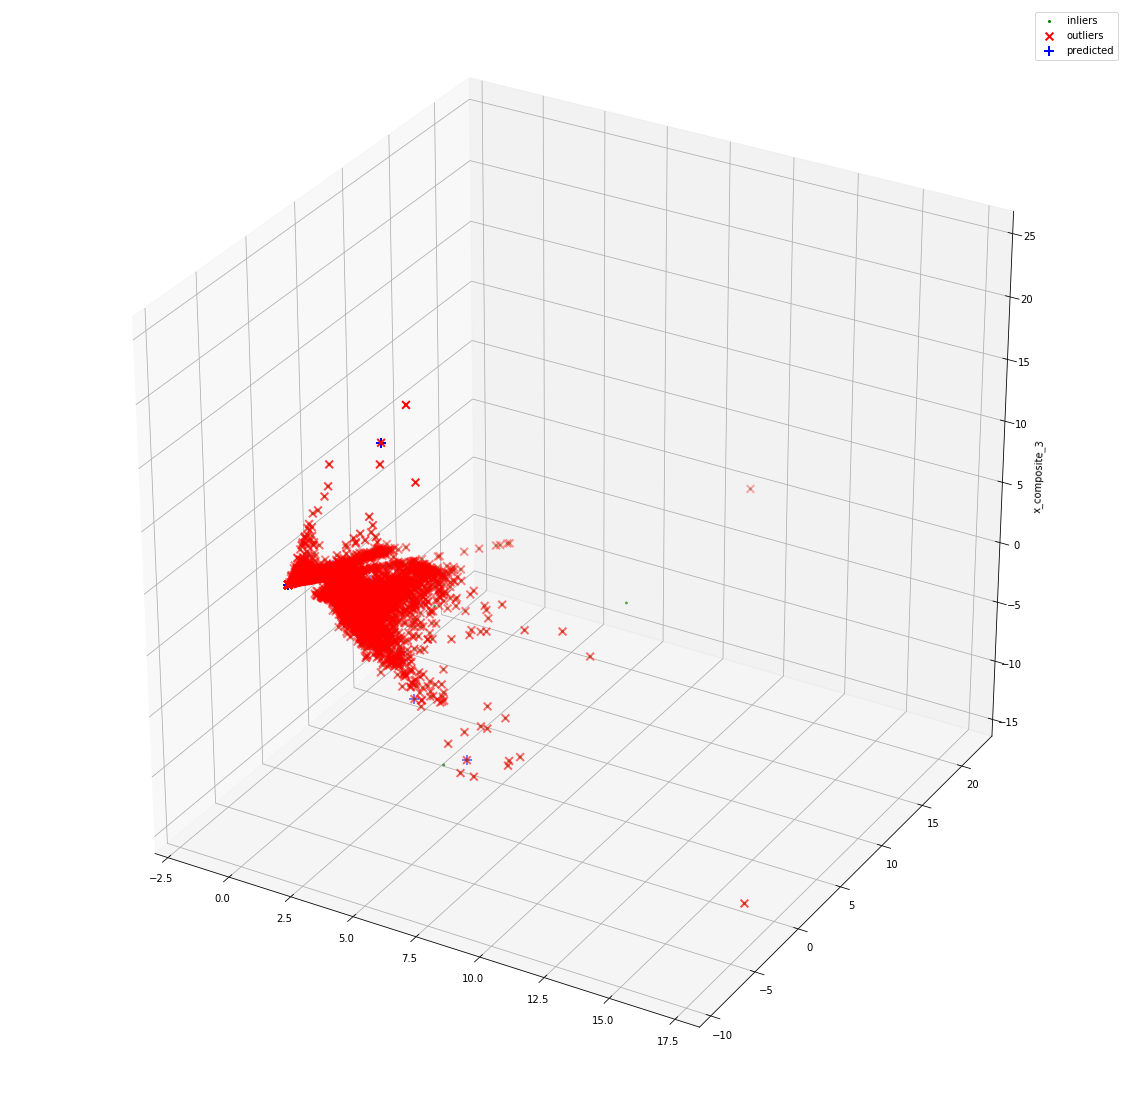

In [332]:
plot_outliers_dimensions(df, oneclass_svm_best_preds, features = None)

### K-NN Modelling

For our next approach, we're going to take the common K-Nearest Neighbour Algorithm, and detect outliers using an unupervised approach. For this modelling task, we're going to use the PYOD library, which has lots of functions and tools for Outlier Detection.

Again, we would typically split the data into training and test (by rows, not by xi...xj, Y), but for this example we're just going to use the dataset as is.

As we want to create robust models with KNN (which is prone to overfitting), we need to then build several models with k-neighbors of j discrete values (e.g. 10, 20, 30,..., 200).



In [350]:
#simple model!
def knn_model(df, features = None, target_col_name='class', contamination = 0.05):
    
    #KNN classifier uses 0 for normal, so let's do a quick replace
    df['class'] = df['class'].replace({-1: 0})

    #first, select the features from the columns
    if features == None:
        features = []
        for col in df.columns:
            if (col != target_col_name) and (col != 'preds'):
                features.append(col)
    
    print(features)
    X_data = df[features]
    y_data = df[target_col_name]
    #first we need to standardize the daataset
    
    clf_name = 'KNN'
    clf = KNN()
    clf.fit(X_data)
    
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_ 
    print(y_train_pred)
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_data, y_train_scores)
    calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=y_train_pred, printoutput=True)
    
knn_model(df)
    

['attr1', 'attr2', 'attr3', 'attr4', 'attr5', 'attr6']
[0 0 0 ... 0 0 0]

On Training Data:
KNN ROC:0.8387, precision @ rank n:0.2192
Positive Records 260, Negative Records 0
Detection Results (Absolute):
True Positive 119
True Negative 9923
False Positive 1000
False Negative 141
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     10923
           1       0.11      0.46      0.17       260

    accuracy                           0.90     11183
   macro avg       0.55      0.68      0.56     11183
weighted avg       0.97      0.90      0.93     11183



k_list of detectors [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900, 910, 920, 930, 940, 950, 960, 970, 980, 990, 1000]
Modelling for 10
Modelling for 110
Modelling for 210
Modelling for 310
Modelling for 410
Modelling for 510
Modelling for 610
Modelling for 710
Modelling for 810
Modelling for 910
0    6900
1    4283
Name: y_by_average_cluster, dtype: int64


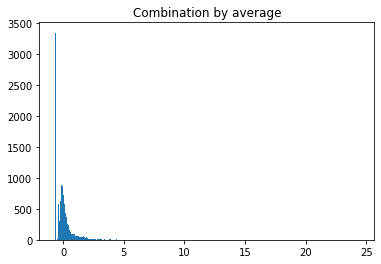

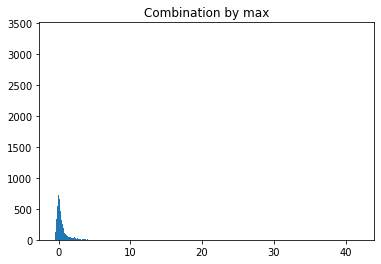

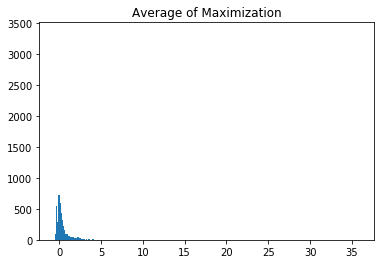

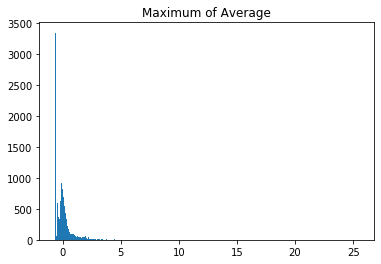

Performance for Average
Positive Records 260, Negative Records 0
Detection Results (Absolute):
True Positive 230
True Negative 6870
False Positive 4053
False Negative 30
              precision    recall  f1-score   support

           0       1.00      0.63      0.77     10923
           1       0.05      0.88      0.10       260

    accuracy                           0.63     11183
   macro avg       0.52      0.76      0.44     11183
weighted avg       0.97      0.63      0.76     11183

Performance for Maximization
Positive Records 260, Negative Records 0
Detection Results (Absolute):
True Positive 243
True Negative 5866
False Positive 5057
False Negative 17
              precision    recall  f1-score   support

           0       1.00      0.54      0.70     10923
           1       0.05      0.93      0.09       260

    accuracy                           0.55     11183
   macro avg       0.52      0.74      0.39     11183
weighted avg       0.97      0.55      0.68     11183

P

In [34]:
def convert_anomaly_score_to_label(scores, class_threshold = 0):
    
    labels = []
    for score in scores:
        if score > class_threshold:
            labels.append(1)
        else:
            labels.append(0)
    return labels

#model combination - more hardcore
def knn_model_combination(df, features = None, target_col_name='class', contamination = 0.05, k_detectors = 100):
    
    #KNN classifier uses 0 for normal, so let's do a quick replace
    df['class'] = df['class'].replace({-1: 0})

    #first, select the features from the columns
    if features == None:
        features = []
        for col in df.columns:
            if (col != target_col_name) and (col != 'preds'):
                features.append(col)
    
    
    X_data = df[features]
    y_data = df[target_col_name]
    
    #standaize the data
    X_train_norm, X_test_norm = standardizer(X_data, X_data)


    # initialize 20 base detectors for combination
    k_list = []
    step = 10
    max_k = (k_detectors * step) + 10 #always offset by 10
    for j in range(10,max_k, step):
        k_list.append(j)
    print('k_list of detectors {}'.format(k_list))
    
    clf_name = 'KNN'
    n_clf = len(k_list)
    train_scores = np.zeros([X_data.shape[0], n_clf])

    for i in range(n_clf):
        if i % 10 ==0:
            print('Modelling for {}'.format(k_list[i]))
        k = k_list[i]
        clf = KNN(n_neighbors=k, method='largest', contamination=contamination, n_jobs=-1)
        clf.fit(X_train_norm)
        train_scores[:, i] = clf.decision_scores_
#         print('Threshold {}'.format(clf.threshold_))
    train_scores_norm, test_scores_norm = standardizer(train_scores,train_scores)
    
    y_by_average = average(test_scores_norm)
#     print(y_by_average)
    y_by_maximization = maximization(test_scores_norm)
    y_by_aom = aom(test_scores_norm, n_buckets=5)
    y_by_moa = moa(test_scores_norm, n_buckets=5)
    
    df_test = pd.DataFrame(X_data)
    df_test['y_by_average_score'] = y_by_average
    df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<0, 0, 1)
    print(df_test['y_by_average_cluster'].value_counts())
    
#     print(df_test.groupby('y_by_average_cluster').mean())

    plt.hist(y_by_average, bins='auto') # arguments are passed to np.histogram
    plt.title("Combination by average")
    plt.show()
    
    plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
    plt.title("Combination by max")
    plt.show()
    
    plt.hist(y_by_aom, bins='auto')  # arguments are passed to np.histogram
    plt.title("Average of Maximization")
    plt.show()
    
    plt.hist(y_by_moa, bins='auto')  # arguments are passed to np.histogram
    plt.title("Maximum of Average")
    plt.show()
    
    
    #niow use our old method to determine how well the model is performing:
    preds_average = convert_anomaly_score_to_label(y_by_average)
    preds_maximization = convert_anomaly_score_to_label(y_by_maximization)
    preds_moa = convert_anomaly_score_to_label(y_by_moa)
    preds_aom = convert_anomaly_score_to_label(y_by_aom)

    print('Performance for Average')
    calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=preds_average, printoutput=True)
    
    print('Performance for Maximization')
    calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=preds_maximization, printoutput=True)
    
    print('Performance for Avg of Maximization')
    calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=preds_moa, printoutput=True)
    
    print('Performance for Max of Avg')
    calculate_model_performance(df, target_col_name='class', target_class_label=1,
                                           preds=preds_aom, printoutput=True)

#as before, we know that the features identified before are the most useful for detecting outliers, so we will reuse
knn_model_combination(df)

**Interpretation of Model**

Ok, so let's take a look at the model output. When we apply a large number of detectors to avoid overfitting, we're seeing pretty good a recall score (remember recall is the number of actual correct matches) for the outlier class.

 precision    recall  f1-score   support

           0       1.00      0.56      0.72     10923
           1       0.05      0.92      0.09       260

    accuracy                           0.57     11183
    macro avg      0.52      0.74      0.40     11183
    weighted avg   0.97      0.57      0.70     11183



## Robust Random Cut Forest

The Robust Random Cut Forest (RRCF) algorithm is an ensemble method for detecting outliers in streaming data. RRCF offers a number of features that many competing anomaly detection algorithms lack. Specifically, RRCF:



In [185]:
df_timeseries = load_data("data/AWSCloudwatch/ec2_cpu_utilization_c6585a.csv")


---
Data Shape:
Total Records 4032
Total Columns 2
Column Names ['timestamp', 'value']
---
Descriptive Stats:
             value
count  4032.000000
mean      0.086948
std       0.085212
min       0.062000
25%       0.066000
50%       0.066000
75%       0.068000
max       1.602000
Column: timestamp
Column is non-integer
Column: value
Skew: 14.111833036269779
Kurtosis: 222.72987257759556


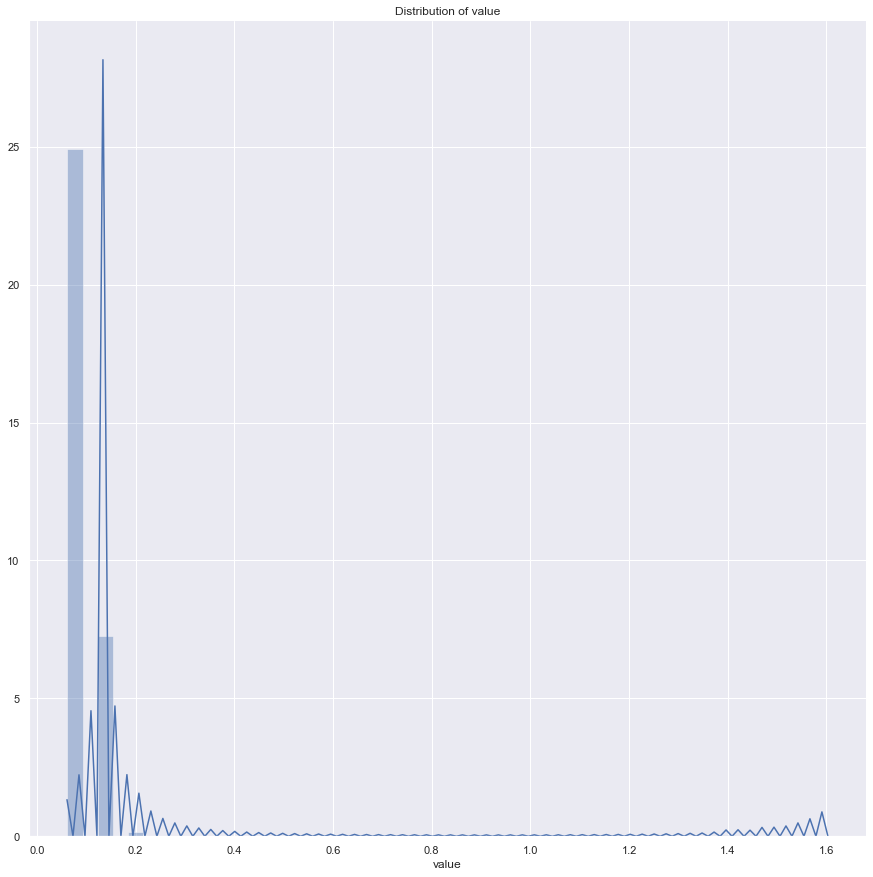

Cross Attribute Plot:


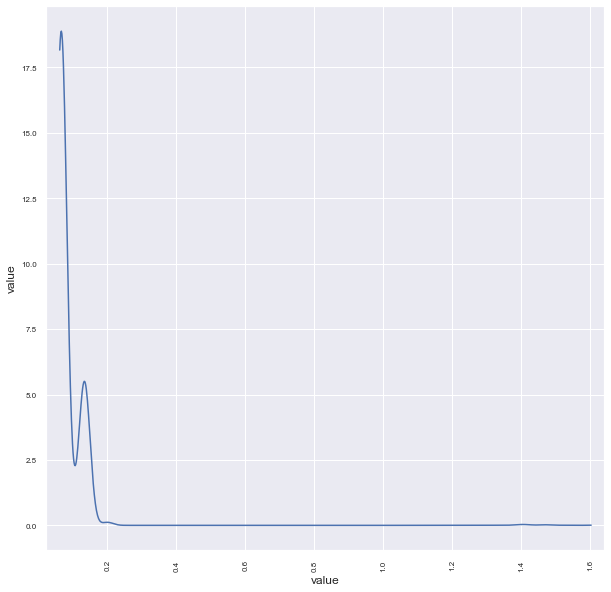

In [186]:
describe_data(df_timeseries)

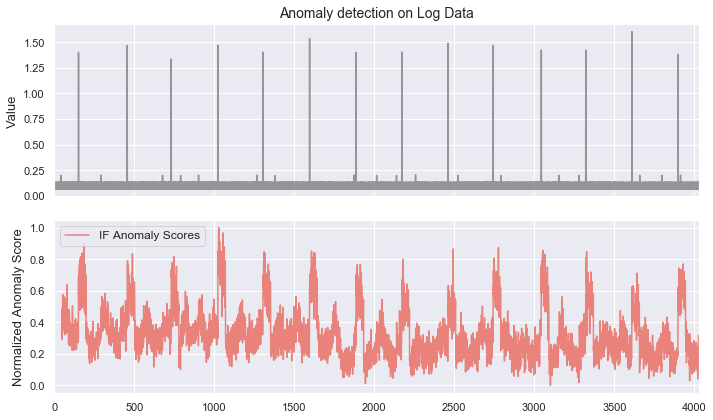

In [187]:
def isolation_forest(df, target_col_name='value', num_trees = 200,):
    contamination = 0.0001
    shingle_size = 48

    
    X = df[target_col_name].astype(float).values
    
    points = rrcf.shingle(X, size=shingle_size)
    points = np.vstack([point for point in points])
    n = points.shape[0]
    
    IF = IsolationForest(n_estimators=num_trees,
                         contamination=contamination,
                         behaviour='new',
                         random_state=0)
    IF.fit(points)
    if_scores = IF.score_samples(points)
    if_scores = pd.Series(-if_scores,
                          index=(df
                                 .iloc[(shingle_size - 1):]
                                 .index))
    
    if_scores = ((if_scores - if_scores.min())
              / (if_scores.max() - if_scores.min()))
    
    
    fig, ax = plt.subplots(2, figsize=(10, 6))
    df['value'].plot(ax=ax[0], color='0.5',
                            alpha=0.8)
    if_scores.plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='IF Anomaly Scores')
    
    ax[1].legend(frameon=True, loc=2, fontsize=12)
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('Value', size=13)
    ax[1].set_ylabel('Normalized Anomaly Score', size=13)
    ax[0].set_title('Anomaly detection on Log Data',
                size=14)   
    ax[0].xaxis.set_ticklabels([])
    ax[0].set_xlim(df.index[0], df.index[-1])
    ax[1].set_xlim(df .index[0], df.index[-1])
    plt.tight_layout()
    
isolation_forest(df_timeseries)

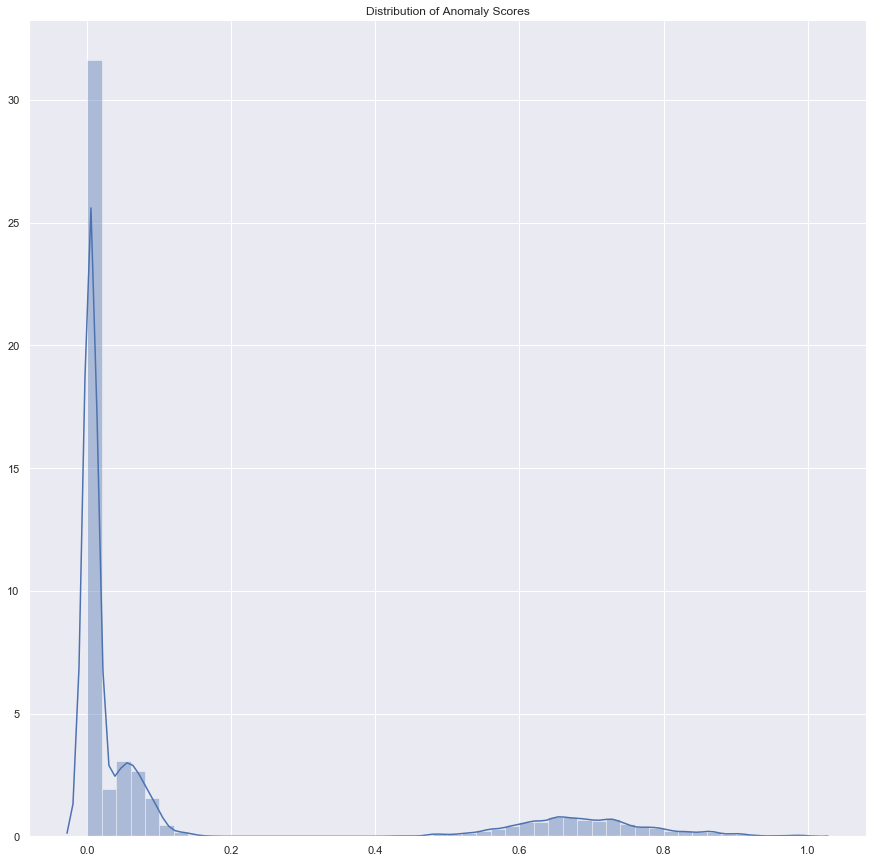

<Figure size 1440x2160 with 0 Axes>

Anomaly Score Threshold Set to 0.7320289316307775


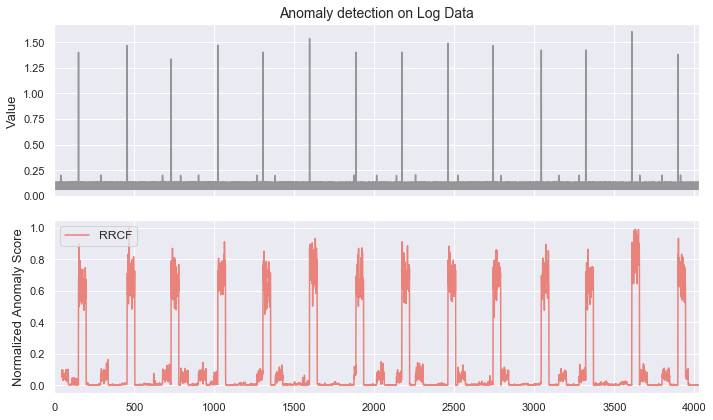

In [189]:
import rrcf

def rrcf_model(df, target_col_name='value', num_trees = 200, tree_size = 1000, contamination = 0.02):
    
    shingle_size = 48

    X = df[target_col_name].astype(float).values
    
    points = rrcf.shingle(X, size=shingle_size)
    points = np.vstack([point for point in points])
    n = points.shape[0]

    sample_size_range = (n // tree_size, tree_size)
    
    # Construct forest
    forest = []
    while len(forest) < num_trees:
        # Select random subsets of points uniformly
        ixs = np.random.choice(n, size=sample_size_range,
                               replace=False)
        # Add sampled trees to forest
        trees = [rrcf.RCTree(points[ix], index_labels=ix)
                 for ix in ixs]
        forest.extend(trees)
        
    # Compute average CoDisp
    avg_codisp = pd.Series(0.0, index=np.arange(n))
    index = np.zeros(n)
    for tree in forest:
        codisp = pd.Series({leaf : tree.codisp(leaf)
                           for leaf in tree.leaves})
        avg_codisp[codisp.index] += codisp
        np.add.at(index, codisp.index.values, 1)
    avg_codisp /= index
    avg_codisp.index = df.iloc[(shingle_size - 1):].index
    
    #normalize between 0,1
    avg_codisp = ((avg_codisp - avg_codisp.min())
              / (avg_codisp.max() - avg_codisp.min()))
    
#     likihood = n - ()
    threshold = avg_codisp.quantile(0.95) #avg_codisp.mode()

    sns.set(rc={'figure.figsize':(15,15)})
    sns.distplot(avg_codisp)
    plt.title("Distribution of Anomaly Scores")
    sns.despine()
    plt.figure(figsize=(20,30))
    plt.show()

    print('Anomaly Score Threshold Set to {}'.format(threshold))

    
    fig, ax = plt.subplots(2, figsize=(10, 6))
    df['value'].plot(ax=ax[0], color='0.5',
                            alpha=0.8)
    avg_codisp.plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='RRCF')
    
    ax[1].legend(frameon=True, loc=2, fontsize=12)
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('Value', size=13)
    ax[1].set_ylabel('Normalized Anomaly Score', size=13)
    ax[0].set_title('Anomaly detection on Log Data',
                size=14)   
    ax[0].xaxis.set_ticklabels([])
    ax[0].set_xlim(df.index[0], df.index[-1])
    ax[1].set_xlim(df .index[0], df.index[-1])
    plt.tight_layout()
    
rrcf_model(df_timeseries)

    

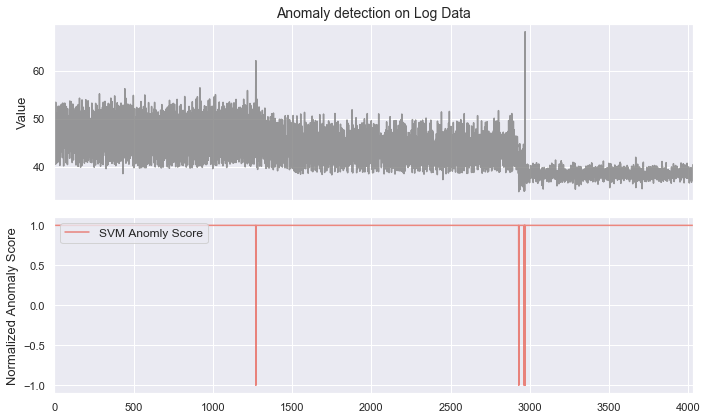

In [176]:
def oneclass_svm(df, target_col_name = 'value'):
    
    
    X = df[target_col_name].astype(float).values
    X = X.reshape(-1,1)

    svm = OneClassSVM(kernel='rbf', nu=.001, gamma=0.00001) 
    svm.fit(X)
    preds = svm.predict(X)
    df['preds'] = preds
#     print(np.unique(preds))

    fig, ax = plt.subplots(2, figsize=(10, 6))
    df['value'].plot(ax=ax[0], color='0.5',
                            alpha=0.8)
    df['preds'].plot(ax=ax[1], color='#E8685D', alpha=0.8,
                label='SVM Anomly Score')
    
    ax[1].legend(frameon=True, loc=2, fontsize=12)
    ax[0].set_xlabel('')
    ax[1].set_xlabel('')
    ax[0].set_ylabel('Value', size=13)
    ax[1].set_ylabel('Normalized Anomaly Score', size=13)
    ax[0].set_title('Anomaly detection on Log Data',
                size=14)   
    ax[0].xaxis.set_ticklabels([])
    ax[0].set_xlim(df.index[0], df.index[-1])
    ax[1].set_xlim(df .index[0], df.index[-1])
    plt.tight_layout()
    
    return svm, preds

preds_svm = oneclass_svm(df)